The below code will create training and test datasets of aviation fuel relevant candidate molecules. 

As input, it uses full GDB-17, unsaturated hydrocarbon GDB-13 and Coconut, a natural products molecular dataset. The notebook will filter out molecules containing non-C/H atoms, check for C6-C20, reject olefinic / acetylenic molecules, and perform a duplicate check. 
The remaining molecules are normalised based on C count, and filtered down to 12_500 / 100_000 molecules. These is further split 80/20 to train/test. 

End deliverables: 
- `combinedSet_10k.csv`
- `combinedSet_80k.csv`

Later, some brief exploratory data analysis is conducted on the remaining main `combinedSet_10k.csv` set. 

Please note that the download of GDB-17 is around 300MB, and the unpacked file is ca 1.5GB. Full coconut set is around 650 MB. Also note, that the filtering takes around 45 minutes on my personal computer, mostly due to the large size of GDB-17. 

### Imports and config

In [ ]:
import sys
import csv
import gzip
import io
import math
import pathlib
import random
import shutil
import subprocess
import tarfile
import time
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from rdkit.Contrib.SA_Score import sascorer
from tqdm.auto import tqdm
csv.field_size_limit(sys.maxsize)

# URLs
URL_GDB17 = ("https://zenodo.org/record/5172018/files/GDB17.50000000.smi.gz?download=1&ref=gdb.unibe.ch")
URL_GDB13 = ("https://zenodo.org/record/5172018/files/gdb13.g.tgz?download=1&ref=gdb.unibe.ch")
URL_COCONUT = ("https://coconut.s3.uni-jena.de/prod/downloads/2025-07/coconut_csv-07-2025.zip")

# File-system layout
DATA_DIR   = pathlib.Path("data/")
DATA_DIR.mkdir(parents=True, exist_ok=True)

GDB17_GZ   = DATA_DIR / "GDB17.50000000.smi.gz"
GDB17_RAW  = DATA_DIR / "GDB17_raw.smi"

GDB13_TGZ  = DATA_DIR / "gdb13.g.tgz"
GDB13_DIR  = DATA_DIR / "gdb13_smi"      # where the 1.g.smi … 13.g.smi land

COCONUT_ZIP = DATA_DIR / "coconut_csv-07-2025.zip"
COCONUT_RAW = DATA_DIR / "coconut_csv-07-2025.csv"

VALID_PATH = DATA_DIR / "filtered_saf_candidates.csv"         # with SA + C count, header
ALL_PATH   = DATA_DIR / "combinedSet_all.csv"                 # header-less SMILES
TRAIN_PATH = DATA_DIR / "combinedSet_10k.csv"
TEST_PATH  = DATA_DIR / "combinedSet_test.csv"

LARGE_ALL_PATH = DATA_DIR / "combinedSet_all_large.csv"
LARGE_TRAIN_PATH = DATA_DIR / "combinedSet_80k.csv"
LARGE_TEST_PATH = DATA_DIR / "combinedSet_test_large.csv"
LARGE_VALID_PATH = DATA_DIR / "filtered_saf_candidates_large.csv"

# Constants as a parameter dictionary
PARAMS = {
    "TOTAL_LINES":   50_000_000,    # tqdm reference for progress bar
    "CARBON_LO":     6,
    "CARBON_HI":     20,
    "MAX_RINGS":     3,
    "MAX_ARO_RINGS": 1,
    "TARGET_N":      12_500,
    "TARGET_N_LARGE": 100_000,  # for large dataset
    "TRAIN_FRAC":    0.80,
    "SEED":          27,
}

# For convenience, unpack to variables
TOTAL_LINES   = PARAMS["TOTAL_LINES"]
CARBON_LO     = PARAMS["CARBON_LO"]
CARBON_HI     = PARAMS["CARBON_HI"]
MAX_RINGS     = PARAMS["MAX_RINGS"]
MAX_ARO_RINGS = PARAMS["MAX_ARO_RINGS"]
TARGET_N      = PARAMS["TARGET_N"]
TRAIN_FRAC    = PARAMS["TRAIN_FRAC"]
SEED          = PARAMS["SEED"]

random.seed(SEED)

print("Configuration loaded.")

Configuration loaded.


### Dataset downoad and extraction

In [2]:
def _download(url, dst):
    if dst.exists():
        return
    print(f"Downloading {dst.name}...")
    subprocess.run(["wget", "-q", "-O", str(dst), url], check=True)

def _extract_coconut():
    if COCONUT_RAW.exists():
        return
    _download(URL_COCONUT, COCONUT_ZIP)
    print("Extracting Coconut dataset...")
    subprocess.run(["unzip", "-q", str(COCONUT_ZIP), "-d", str(DATA_DIR)], check=True)
    print("Coconut dataset ready.")

def _extract_gdb13():
    if GDB13_DIR.exists():
        return
    _download(URL_GDB13, GDB13_TGZ)
    print("Extracting GDB-13 tgz...")
    with tarfile.open(GDB13_TGZ, "r:gz") as tar:
        tar.extractall(path=GDB13_DIR)
    print("GDB-13 ready ({} files).".format(len(list(GDB13_DIR.glob("*.smi")))))

def _extract_gdb17():
    if GDB17_RAW.exists():
        return
    _download(URL_GDB17, GDB17_GZ)
    print("Decompressing GDB-17 slice...")
    with gzip.open(GDB17_GZ, "rb") as gz_in, GDB17_RAW.open("wb") as f_out:
        shutil.copyfileobj(gz_in, f_out)
    print("GDB-17 ready.")

_extract_gdb13()
_extract_coconut()
_extract_gdb17()

print("All input datasets present.")

All input datasets present.


### Utility helpers

In [3]:
def _iter_smi_file(path):
    """
    Yield raw SMILES strings from a .smi (no header) or .csv (first column) file.
    """
    with path.open() as f:
        if path.suffix == ".csv":
            reader = csv.reader(f)
            _ = next(reader, None)    # skip header
            for row in reader:
                if row:
                    yield row[0].strip()
        else:                         # .smi   "SMILES [tab] id"
            for line in f:
                if line.strip():
                    yield line.split()[0]

def _passes_filters(mol):
    """
    Pre-filters for the SAF dataset
      - atoms limited to C and H
      - <= 20 carbon atoms
      - no C=C or C≡C bonds (reject olefinic / acetylenic molecules)
    """
    # 1. Elemental composition: C/H only
    if any(a.GetAtomicNum() not in (6, 1) for a in mol.GetAtoms()):
        return False

    # 2. Carbon-count limit (<= 20)
    if sum(1 for a in mol.GetAtoms() if a.GetAtomicNum() == 6) > 20:
        return False

    # 3. Saturation: reject any non-single or aromatic bond
    for b in mol.GetBonds():
        if b.GetBondType() != Chem.rdchem.BondType.SINGLE or b.GetIsAromatic():
            return False

    return True


def _count_carbons(smi: str) -> int:
    """Return the number of carbon atoms in a SMILES string.
       Assumes the string is valid; returns -1 if RDKit parsing fails."""
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        return -1
    return sum(1 for a in mol.GetAtoms() if a.GetAtomicNum() == 6)

### Initial dataset filtering

In [4]:
t0 = time.perf_counter()

canonical_seen  = set()
valid_records   = []          # (canonical, SA, C)

# Coconut dataset (single big csv file)
print("\nFiltering Coconut dataset ...")
with tqdm(total=None, unit="lines") as bar:
    with COCONUT_RAW.open() as f:
        reader = csv.DictReader(f)
        for row in reader:
            bar.update(1)
            raw = row.get("canonical_smiles", "").strip()
            mol = Chem.MolFromSmiles(raw, sanitize=False)
            if mol is None:
                continue
            try:
                Chem.SanitizeMol(mol)
                Chem.RemoveStereochemistry(mol)          # stereo irrelevant to fuel domain
            except Exception:
                continue
            if not _passes_filters(mol):                 # C/H only, <=20 C, saturated
                continue
            can = Chem.MolToSmiles(mol, canonical=True)
            if can in canonical_seen:                    # skip intra-Coconut duplicates
                continue
            canonical_seen.add(can)
            sa = sascorer.calculateScore(mol)
            c_count = mol.GetNumAtoms()
            valid_records.append((can, sa, c_count))
    bar.close()

# GDB-13  (13 per-C-count files)
print("\nFiltering GDB-13 ...")
gdb13_files = sorted(GDB13_DIR.glob("*.smi"))
for p in tqdm(gdb13_files, desc="GDB-13 files"):
    for raw in _iter_smi_file(p):
        mol = Chem.MolFromSmiles(raw, sanitize=False)
        if mol is None or not _passes_filters(mol):
            continue
        try:
            Chem.SanitizeMol(mol)
        except Exception:
            continue
        can = Chem.MolToSmiles(mol, canonical=True)
        if can in canonical_seen:
            continue
        canonical_seen.add(can)
        sa = sascorer.calculateScore(mol)
        c_count = mol.GetNumAtoms()
        valid_records.append((can, sa, c_count))
print(f"GDB-13: cumulative total now {len(valid_records):,} molecules.")


# GDB-17  (single huge file)
print("\nFiltering GDB-17 ...")
with tqdm(total=TOTAL_LINES, unit="lines") as bar:
    for raw in _iter_smi_file(GDB17_RAW):
        bar.update(1)
        mol = Chem.MolFromSmiles(raw, sanitize=False)
        if mol is None or not _passes_filters(mol):
            continue
        try:
            Chem.SanitizeMol(mol)
        except Exception:
            continue
        can = Chem.MolToSmiles(mol, canonical=True)
        if can in canonical_seen:
            continue
        canonical_seen.add(can)
        sa = sascorer.calculateScore(mol)
        c_count = mol.GetNumAtoms()
        valid_records.append((can, sa, c_count))
bar.close()
print(f"GDB-17: kept {len(valid_records):,} molecules.")


print(f"After all three sources: {len(valid_records):,} unique molecules.")
print(f"Filtering completed in {time.perf_counter() - t0:,.1f} s.")


Filtering Coconut dataset ...


0lines [00:00, ?lines/s]

275158lines [01:14, 4004.26lines/s][04:45:30] Explicit valence for atom # 1 P, 6, is greater than permitted
333948lines [01:27, 3713.33lines/s][04:45:44] Explicit valence for atom # 20 N, 5, is greater than permitted
375331lines [01:38, 4449.23lines/s][04:45:54] Explicit valence for atom # 1 P, 6, is greater than permitted
398418lines [01:45, 2404.19lines/s][04:46:01] Unusual charge on atom 37 number of radical electrons set to zero
434266lines [01:55, 4287.52lines/s][04:46:12] Explicit valence for atom # 0 He, 2, is greater than permitted
695119lines [03:02, 3803.65lines/s]



Filtering GDB-13 ...


GDB-13 files: 100%|██████████| 13/13 [02:40<00:00, 12.33s/it]


GDB-13: cumulative total now 320,088 molecules.

Filtering GDB-17 ...


100%|██████████| 50000000/50000000 [32:47<00:00, 25407.87lines/s] 

GDB-17: kept 323,392 molecules.
After all three sources: 323,392 unique molecules.
Filtering completed in 2,311.0 s.


Check for duplicates in the current set: 

In [5]:
from collections import Counter

# Extract canonical SMILES strings
smiles_list = [smi for smi, _, _ in valid_records]

# Use Counter to efficiently count occurrences
smiles_counter = Counter(smiles_list)

# Find duplicates (SMILES that appear more than once)
duplicates = [smi for smi, count in smiles_counter.items() if count > 1]

# Create deduplicated list while preserving order
unique_records = []
seen = set()
for record in valid_records:
    smi = record[0]
    if smi not in seen:
        seen.add(smi)
        unique_records.append(record)

# Print results
if duplicates:
    print(f"Found {len(duplicates)} duplicate SMILES in valid_records")
    print(f"First few duplicates: {duplicates[:5]}")
else:
    print("No duplicate SMILES found in valid_records")

print(f"Original valid_records: {len(valid_records)}")
print(f"After removing duplicates: {len(unique_records)}")

No duplicate SMILES found in valid_records
Original valid_records: 323392
After removing duplicates: 323392


Save set to csv: 

In [6]:
# make a new csv with the smiles of valid records, SA score and C count, named "full_saf_candidates.csv"
FULL_VALID_PATH = DATA_DIR / "full_saf_candidates.csv"
print("\nWriting valid records to CSV...")
with FULL_VALID_PATH.open("w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["SMILES", "SA", "C_count"])  # header
    for smi, sa, c in valid_records:
        writer.writerow([smi, sa, c])
print(f"Valid records written to {FULL_VALID_PATH.name}.")


Writing valid records to CSV...
Valid records written to full_saf_candidates.csv.


### Normalisation for 10k set

In [7]:
print("Normalising based on C count (7-18)...")
min_c, max_c = 7, 18
cs = list(range(min_c, max_c + 1))
# group valid_records by C‐count in the desired window
records_by_c = {c: [(s, sa) for s, sa, c0 in valid_records if c0 == c] for c in cs}

quota = math.ceil(TARGET_N / len(cs))
selected = []

# sample up to quota from each C‐count
for c in cs:
    bucket = records_by_c[c]
    if bucket:
        k = min(len(bucket), quota)
        selected.extend(random.sample(bucket, k))

# if we’re short, fill the remainder at random from all same‐C records
if len(selected) < TARGET_N:
    leftovers = [
        rec for c in cs for rec in records_by_c[c]
        if rec not in selected
    ]
    needed = TARGET_N - len(selected)
    selected.extend(random.sample(leftovers, needed))

# shuffle and trim exactly to TARGET_N
random.shuffle(selected)
selected = selected[:TARGET_N]

print(f"Selected {len(selected):,} molecules.")


Normalising based on C count (7-18)...
Selected 12,500 molecules.


In [8]:
print("Normalising based on C count (7-18) for large dataset...")
min_c, max_c = 7, 18
cs = list(range(min_c, max_c + 1))

# group valid_records by C-count in the desired window
records_by_c = {c: [(s, sa) for s, sa, c0 in valid_records if c0 == c] for c in cs}

# Calculate quota for larger dataset
large_quota = math.ceil(PARAMS["TARGET_N_LARGE"] / len(cs))
large_selected = []

# sample up to quota from each C-count
for c in cs:
    bucket = records_by_c[c]
    if bucket:
        k = min(len(bucket), large_quota)
        large_selected.extend(random.sample(bucket, k))

# if we're short, fill the remainder at random from all same-C records
if len(large_selected) < PARAMS["TARGET_N_LARGE"]:
    leftovers = [
        rec for c in cs for rec in records_by_c[c]
        if rec not in large_selected
    ]
    needed = PARAMS["TARGET_N_LARGE"] - len(large_selected)
    if needed <= len(leftovers):
        large_selected.extend(random.sample(leftovers, needed))
    else:
        print(f"Warning: Not enough molecules to reach target. Only found {len(large_selected) + len(leftovers)}")
        large_selected.extend(leftovers)

# shuffle and trim exactly to TARGET_N_LARGE
random.shuffle(large_selected)
large_selected = large_selected[:PARAMS["TARGET_N_LARGE"]]

print(f"Selected {len(large_selected):,} molecules for large dataset.")

Normalising based on C count (7-18) for large dataset...
Selected 100,000 molecules for large dataset.


### Write to CSVs

In [23]:
all_smiles = [s for s, _sa in selected]

# Create mapping of SMILES to carbon count
smi_to_c = {}
for smi, _, c in valid_records:
    smi_to_c[smi] = c

# Train / test split
split_idx = int(len(all_smiles) * TRAIN_FRAC)
train_smiles = all_smiles[:split_idx]
test_smiles  = all_smiles[split_idx:]

def _dump(path, iterable):
    with path.open("w") as f:
        for smi in iterable:
            f.write(smi + "\n")

_dump(ALL_PATH,   all_smiles)
_dump(TRAIN_PATH, train_smiles)
_dump(TEST_PATH,  test_smiles)

# Also keep a diagnostic file with SA + C (headered)
with VALID_PATH.open("w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["SMILES", "SA", "C"])
    for smi, sa in selected:
        c = smi_to_c[smi]
        w.writerow([smi, f"{sa:.3f}", c])

print(f"Wrote:\n  {ALL_PATH}\n  {TRAIN_PATH}\n  {TEST_PATH}\n  {VALID_PATH}")


Wrote:
  data/combinedSet_all.csv
  data/combinedSet_10k.csv
  data/combinedSet_test.csv
  data/filtered_saf_candidates.csv


In [24]:
# Process large dataset
large_all_smiles = [s for s, _sa in [(rec[0], rec[1]) for rec in large_selected]]

# Train / test split for large dataset
large_split_idx = int(len(large_all_smiles) * TRAIN_FRAC)
large_train_smiles = large_all_smiles[:large_split_idx]
large_test_smiles = large_all_smiles[large_split_idx:]

# Write files
_dump(LARGE_ALL_PATH, large_all_smiles)
_dump(LARGE_TRAIN_PATH, large_train_smiles)
_dump(LARGE_TEST_PATH, large_test_smiles)

# Create mapping of SMILES to carbon count for the large dataset
large_smi_to_c = {}
for smi, _, c in valid_records:
    large_smi_to_c[smi] = c

# Also keep a diagnostic file with SA + C (headered) for large dataset
with LARGE_VALID_PATH.open("w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["SMILES", "SA", "C"])
    for smi, sa in large_selected:
        c = large_smi_to_c.get(smi, _count_carbons(smi))  # Fallback to calculation if not in map
        w.writerow([smi, f"{sa:.3f}", c])

print(f"Wrote large dataset files:\n  {LARGE_ALL_PATH}\n  {LARGE_TRAIN_PATH}\n  {LARGE_TEST_PATH}\n  {LARGE_VALID_PATH}")

Wrote large dataset files:
  data/combinedSet_all_large.csv
  data/combinedSet_100k.csv
  data/combinedSet_test_large.csv
  data/filtered_saf_candidates_large.csv


### General exploratory data analysis (of the smaller set)

In [25]:
# Print longest and shortest SMILES in the dataset, their C counts and overall lengths
def _print_smi_info(smi):
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        return None
    c_count = mol.GetNumAtoms()
    return smi, c_count, len(smi)

longest = max(all_smiles, key=lambda s: len(s))
shortest = min(all_smiles, key=lambda s: len(s))
longest_info = _print_smi_info(longest)
shortest_info = _print_smi_info(shortest)
print(f"\nLongest SMILES: {longest_info[0]} (C: {longest_info[1]}, Length: {longest_info[2]})")
print(f"Shortest SMILES: {shortest_info[0]} (C: {shortest_info[1]}, Length: {shortest_info[2]})") 


Longest SMILES: CCC1(C)CC2C(C)(C)C(C)(C)C1(C)C2(C)C (C: 17, Length: 35)
Shortest SMILES: CCCCCCC (C: 7, Length: 7)


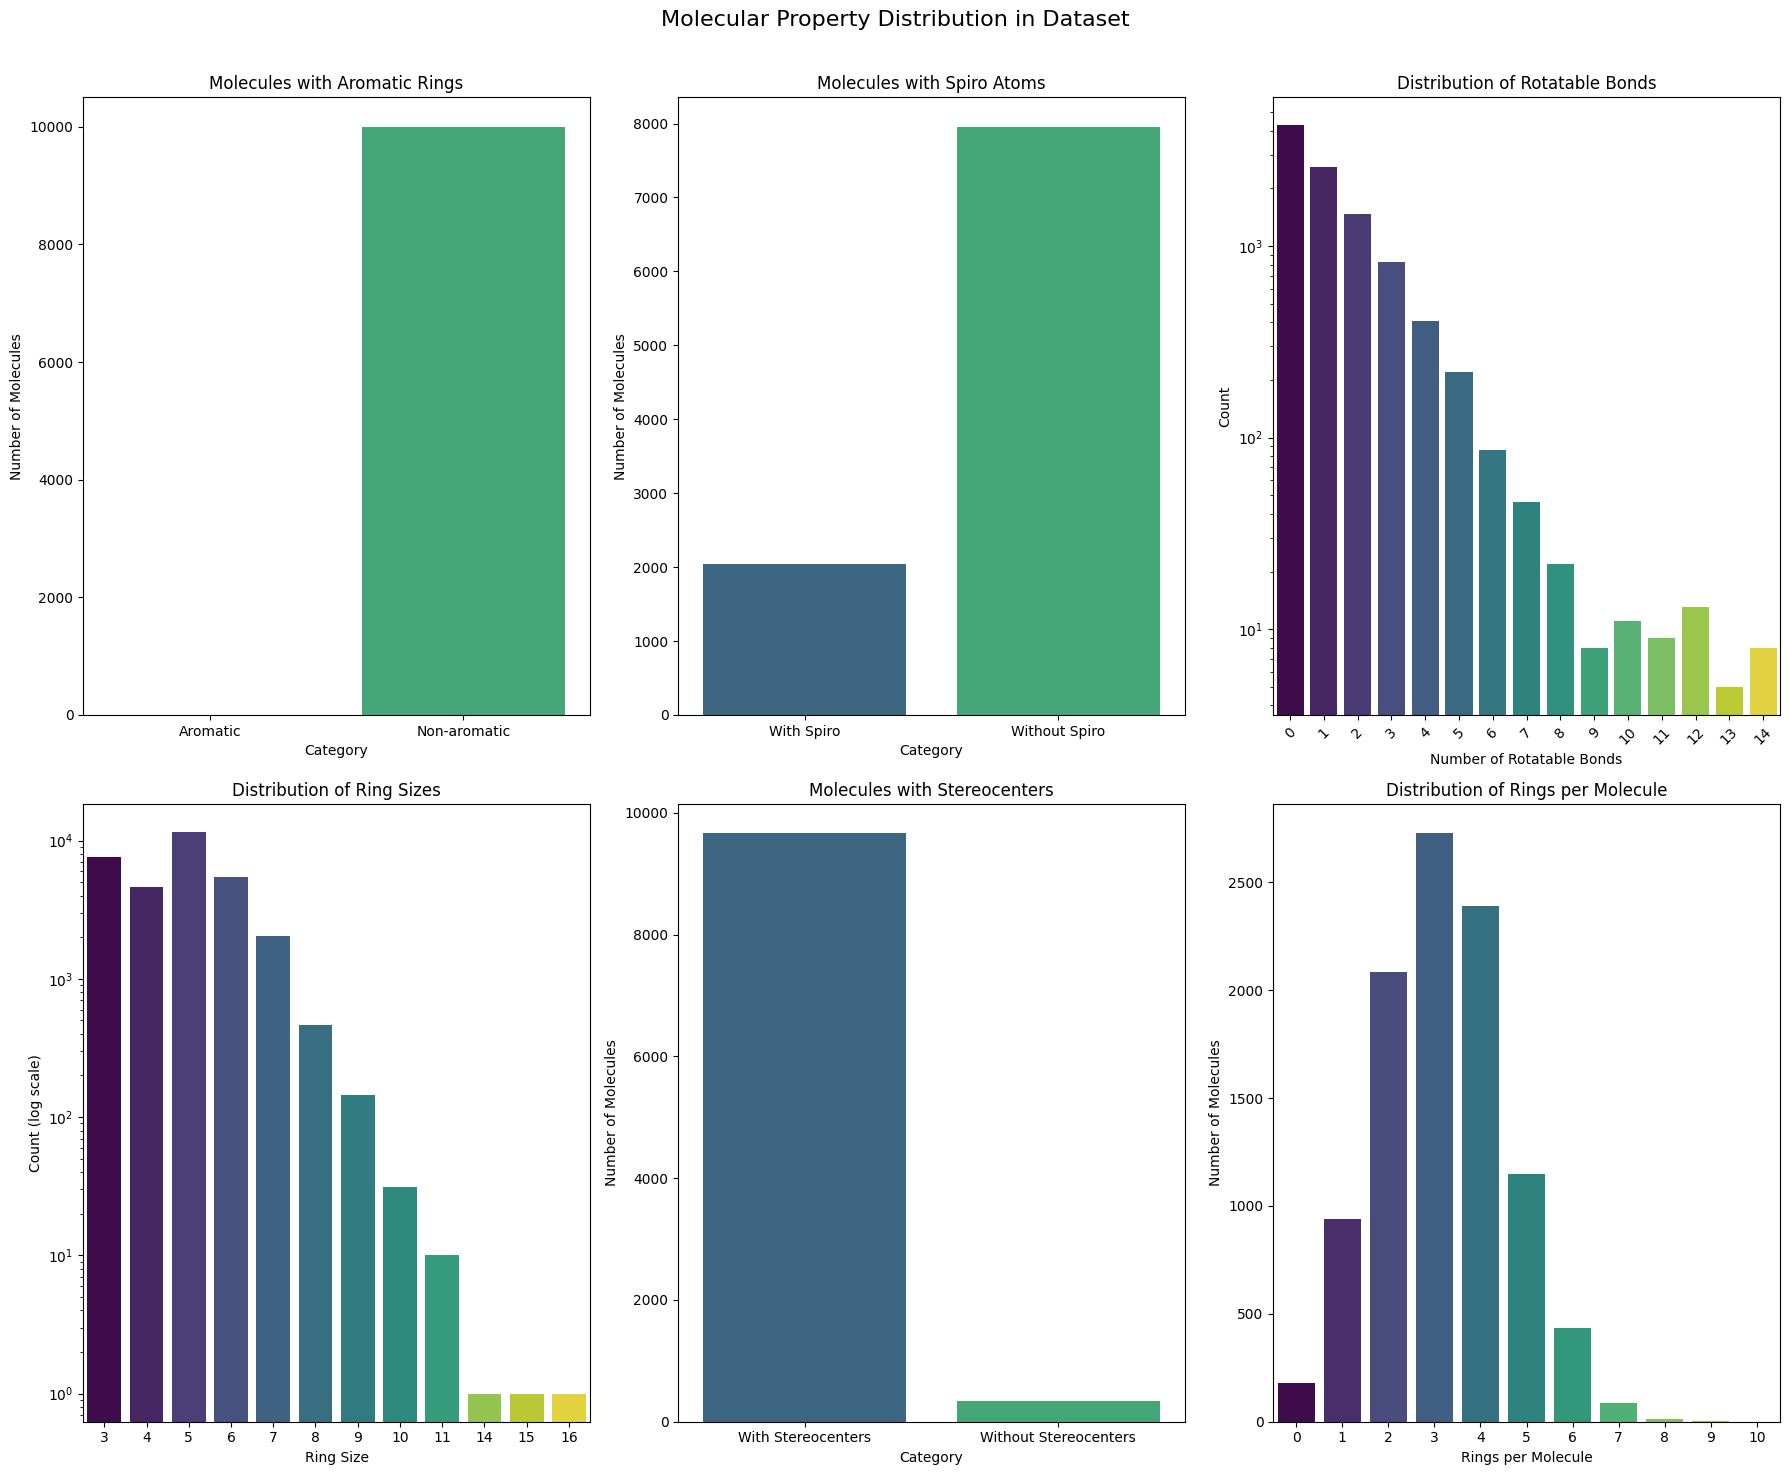

In [49]:
ring_count = 0
six_membered = 0
ring_sizes = Counter()
macrocycle_count = 0
total_mols = 0

with TRAIN_PATH.open() as f:
    reader = csv.reader(f); next(reader, None)
    for smi, *_ in reader:
        mol = Chem.MolFromSmiles(smi)
        if mol:
            total_mols += 1
            ri = mol.GetRingInfo()
            ring_count += ri.NumRings()
            for ring in ri.AtomRings():
                ring_size = len(ring)
                ring_sizes[ring_size] += 1
                if ring_size >= 8:
                    macrocycle_count += 1
            six_membered += sum(1 for ring in ri.AtomRings() if len(ring) == 6)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# create a figure with multiple subplots
fig = plt.figure(figsize=(18, 15))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

# make bar chart for aromatic vs non-aromatic
ax1 = plt.subplot(2, 3, 1)
aromatic_data = pd.DataFrame({
    'Category': ['Aromatic', 'Non-aromatic'],
    'Count': [aromatic_count, total_mols - aromatic_count]
})
sns.barplot(x='Category', y='Count', hue='Category', data=aromatic_data, palette='viridis', legend=False, ax=ax1)
ax1.set_title('Molecules with Aromatic Rings')
ax1.set_ylabel('Number of Molecules')

# make bar chart for spiro atoms
ax2 = plt.subplot(2, 3, 2)
spiro_data = pd.DataFrame({
    'Category': ['With Spiro', 'Without Spiro'],
    'Count': [spiro_count, total_mols - spiro_count]
})
sns.barplot(x='Category', y='Count', hue='Category', data=spiro_data, palette='viridis', legend=False, ax=ax2)
ax2.set_title('Molecules with Spiro Atoms')
ax2.set_ylabel('Number of Molecules')

# check rotatable bonds distribution
ax3 = plt.subplot(2, 3, 3)
rotb_df = pd.DataFrame({'Number of Rotatable Bonds': list(rotb_counts.keys()), 
                        'Count': list(rotb_counts.values())})
rotb_df = rotb_df.sort_values('Number of Rotatable Bonds')
# Fix for ticklabels warning - set ticks first
ax3.set_xticks(range(len(rotb_df)))
ax3.set_xticklabels(rotb_df['Number of Rotatable Bonds'], rotation=45)
# Then plot
sns.barplot(x='Number of Rotatable Bonds', y='Count', hue='Number of Rotatable Bonds', 
            data=rotb_df, palette='viridis', legend=False, ax=ax3)
ax3.set_title('Distribution of Rotatable Bonds')
ax3.set_yscale('log')

# check ring size distribution
ax4 = plt.subplot(2, 3, 4)
ring_df = pd.DataFrame({
    'Ring Size': list(ring_sizes.keys()), 
    'Count': list(ring_sizes.values())
})
ring_df = ring_df.sort_values('Ring Size')
sns.barplot(x='Ring Size', y='Count', hue='Ring Size', 
            data=ring_df, palette='viridis', legend=False, ax=ax4)
ax4.set_title('Distribution of Ring Sizes')
ax4.set_yscale('log')
ax4.set_ylabel('Count (log scale)')

# check chirality
ax5 = plt.subplot(2, 3, 5)
chiral_data = pd.DataFrame({
    'Category': ['With Stereocenters', 'Without Stereocenters'],
    'Count': [chiral_mols, total_mols - chiral_mols]
})
sns.barplot(x='Category', y='Count', hue='Category', 
            data=chiral_data, palette='viridis', legend=False, ax=ax5)
ax5.set_title('Molecules with Stereocenters')
ax5.set_ylabel('Number of Molecules')

# 6. Rings per molecule distribution
ax6 = plt.subplot(2, 3, 6)
# We need to calculate this
rings_per_mol = Counter()
with TRAIN_PATH.open() as f:
    reader = csv.reader(f); next(reader, None)
    for smi, *_ in reader:
        mol = Chem.MolFromSmiles(smi)
        if mol:
            ri = mol.GetRingInfo()
            rings_per_mol[ri.NumRings()] += 1

rings_df = pd.DataFrame({
    'Rings per Molecule': list(rings_per_mol.keys()),
    'Count': list(rings_per_mol.values())
})
rings_df = rings_df.sort_values('Rings per Molecule')
sns.barplot(x='Rings per Molecule', y='Count', hue='Rings per Molecule', 
            data=rings_df, palette='viridis', legend=False, ax=ax6)
ax6.set_title('Distribution of Rings per Molecule')
ax6.set_ylabel('Number of Molecules')

plt.suptitle('Molecular Property Distribution in Dataset', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [44]:
import math
from typing import Dict, Tuple, List, Optional
from rdkit.Chem import Descriptors
from collections import defaultdict
from chemicals.volume import Yamada_Gunn


# Marrero-Gani group contribution method for chemical properties
# -------------------------------------------------------------------------
#  Group-contribution tables

MG1: Dict[str, Tuple[float, ...]] = {
    # key              Tm      Tb      Tc       Pc        Vc      Hvap      Hf
    "CH3": (0.6953, 0.8491, 1.7506, 0.018615, 68.35, 0.217, -42.479),
    "CH2": (0.2515, 0.7141, 1.3327, 0.013547, 56.28, 4.910, -20.829),
    "CH": (-0.3730, 0.2925, 0.5960, 0.007259, 37.50, 7.962, -7.122),
    "C": (0.0256, -0.0671, 0.0306, 0.001219, 16.01, 10.730, 8.928),
    # olefinic
    "CH2=CH": (1.1728, 1.5596, 3.2295, 0.025745, 111.43, 4.031, 57.509),
    "CH=CH": (0.9460, 1.5597, 3.0741, 0.023003, 98.43, 9.456, 69.664),
    "CH2=C": (0.7662, 1.3621, 2.7717, 0.021137, 91.40, 8.602, 61.625),
    "CH=C": (0.1732, 1.2971, 2.5666, 0.019609, 83.89, 14.095, 81.835),
    "C=C": (0.3928, 1.2739, 2.6391, 0.014114, 90.66, 19.910, 95.710),
    # acetylenic
    "CH#C": (2.2276, 1.7618, 3.7897, 0.014010, 84.60, 6.144, 224.902),
    "C#C": (2.0516, 1.6767, 4.5870, 0.010888, 74.66, 12.540, 228.282),
    # saturated rings
    "CH2(cyc)": (0.5699, 0.8234, 1.8815, 0.009884, 49.24, 3.341, -18.575),
    "CH(cyc)": (0.0335, 0.5946, 1.1020, 0.007596, 44.95, 6.416, -12.464),
    "C(cyc)": (0.1695, 0.0386, -0.2399, 0.003268, 33.32, 7.017, -2.098),
    # cyclo‑alkenes
    "CH=CH(cyc)": (1.1936, 1.5985, 3.6426, 0.013815, 83.91, 7.767, 59.841),
    "CH=C(cyc)": (0.4344, 1.2529, 3.5475, 0.010576, 70.98, 7.171, 64.295),
    "CH2=C(cyc)": (0.2220, 1.5109, 4.4913, 0.019101, 83.96, 5.351, 0),
    # special ring‑pair (ignored in SMARTS counting)
    "ACH": (0.5860, 0.8365, 2.0337, 0.007260, 42.39, 3.683, 12.861),
    "AC_subst": (0.9176, 1.5468, 4.5344, 0.012859, 26.47, 6.824, 24.701),
    "AC_fused_ar": (1.8955, 1.7324, 5.4979, 0.003564, 35.71, 6.631, 20.187),
    "AC_fused_nonar": (1.2065, 1.1995, 3.1058, 0.006512, 34.65, 6.152, 30.768),
    "CH(bicyc)": (0.6647, 0.1415, 0.4963, -0.000985, -3.33, 0.223, 0),
    "C(bicyc)": (0.0792, 0.2019, 1.6480, -0.010560, -12.10, -2.030, 0),
    "CH(spiro)": (0.7730, 0.2900, 1.3500, -0.006200, -4.50, -2.600, 0),
    "C(spiro)": (0.1020, 0.2300, 1.7900, -0.011100, -13.20, -2.300, 0),
}

MG2: Dict[str, Tuple[float, ...]] = {
    # branched paraffins
    "(CH3)2CH": (0.1175, -0.0035, -0.0471, 0.000473, 1.71, -0.399, -0.419),
    "(CH3)3C": (-0.1214, 0.0072, -0.1778, 0.000340, 3.14, -0.417, -1.967),
    "CH(CH3)CH(CH3)": (0.2390, 0.3160, 0.5602, -0.003207, -3.75, 0.532, 6.065),
    "CH(CH3)C(CH3)2": (-0.3276, 0.3976, 0.8994, -0.008733, -10.06, 0.623, 8.078),
    "C(CH3)2C(CH3)2": (3.3297, 0.4487, 1.5535, -0.016852, -8.70, 5.086, 10.535),
    # diene / alkene adjacency
    "diene_adj": (0.7451, 0.1097, 0.4214, 0.000792, -7.88, 1.632, -11.786),
    "CH3-alkene": (0.0524, 0.0369, -0.0172, -0.000101, 0.50, 0.064, -0.048),
    "CH2-alkene": (-0.1077, -0.0537, 0.0262, 0.000815, 0.14, -0.060, 1.449),
    "CH-alkene": (-0.2485, -0.0093, -0.1526, -0.000163, -2.67, 0.004, 3.964),
    # alicyclic substitutions
    "Ccyc-CH2": (-1.9233, 0.0319, 0.1090, -0.000610, -5.17, 0.585, 21.498),
    "Ccyc-CH3": (0.1737, 0.0722, 0.1607, 0.001235, 1.95, 0.808, 0.238),
    "CHcyc-CH3": (-0.1326, -0.1210, -0.1233, 0.000779, 2.79, 0.096, 4.452),
    "CHcyc-CH2": (-0.4669, -0.0148, 0.3816, 0.001694, -2.95, -0.428, 4.428),
    "CHcyc-CH": (-0.3548, 0.1395, 0.1093, 0.000124, 6.19, 0.153, -4.128),
    "CHcyc-C": (-0.1727, 0.1829, 0, 0, 0, 0, 0),
    "CHcyc-CH=CH": (0.6817, -0.1192, 0.0000, 0.000000, -16.97, 6.768, 10.390),
    "CHcyc-C=CH": (-1.0631, -0.0455, -0.2832, 0.002114, -16.97, 0.000, 10.390),
    "AROMRINGs1s2": (-0.6388, -0.1590, -0.3161, 0.000522, 2.86, 1.164, 1.486),
}

MG3: Dict[str, Tuple[float, ...]] = {
    "CHcyc-Chcyc": (0.5460, 0.4387, 2.1761, 0.002745, 7.72, 0.0, -66.870),
    "CHcyc-(CHn)m-CHcyc": (0.4497, 0.5632, 0.0000, 0.0000, 0.00, 0.000, 0.0000),
    "CH_multiring": (0.6647, 0.1415, 0.4963, -0.000985, -3.33, 0.223, 0.0),
    "C_multiring": (0.0792, 0.0000, 0.0000, 0.000000, 0.00, 0.000, 0.000),
    "AROMFUSED[2]": (0.2825, 0.0441, -1.0095, -0.001332, -6.88, 0.694, 1.904),
    "AROMFUSED[3]": (1.6600, 0.0402, -1.0430, 0.004695, 35.21, 1.176, 5.819),
    "AROMFUSED[4p]": (-1.5856, 0.9126, 2.8885, 0.007280, -24.02, -3.417, -19.089),
    # Osmont 06
    "BICYC>C<": (0.5500, 0.0700, 0.8900, -0.004400, -6.95, 0.000, 0.0000),
}

# First-order atom-levle classifier for MG1
def _mg1_counts(mol: Chem.Mol) -> Dict[str, int]:
    """Return a mapping {group: count} by classifying every carbon atom."""
    counts: Dict[str, int] = defaultdict(int)

    for atom in mol.GetAtoms():
        if atom.GetSymbol() != "C":
            continue  # ignore heteroatoms

        n_H = atom.GetTotalNumHs()
        in_ring = atom.IsInRing()
        has_double = any(
            b.GetBondType() == Chem.BondType.DOUBLE for b in atom.GetBonds()
        )
        has_triple = any(
            b.GetBondType() == Chem.BondType.TRIPLE for b in atom.GetBonds()
        )

        # aromatic carbons (Marrero-Gani: ACH, AC variants)
        if atom.GetIsAromatic():
            if n_H >= 1:
                counts["ACH"] += 1  # first-order aromatic CH
                continue

            # Substituted aromatic C: need to know whether it is a fusion atom
            ri = mol.GetRingInfo()
            atom_idx = atom.GetIdx()
            # how many aromatic rings contian this atom?
            aro_rings = [
                set(r)
                for r in ri.AtomRings()
                if all(mol.GetAtomWithIdx(i).GetIsAromatic() for i in r)
            ]
            n_arom_memberships = sum(atom_idx in r for r in aro_rings)

            # wheather this atom is also in non-aromatic ring
            nonaro_rings = [
                set(r)
                for r in ri.AtomRings()
                if not all(mol.GetAtomWithIdx(i).GetIsAromatic() for i in r)
            ]
            in_nonaro = any(atom_idx in r for r in nonaro_rings)

            if n_arom_memberships >= 2:
                # shared by two aromatic rings (e.g nafthalene)
                counts["AC_fused_ar"] += 1
            elif in_nonaro:
                # shared by aromatic + non-aromatic ring
                counts["AC_fused_nonar"] += 1
            else:
                counts["AC_subst"] += 1  # substiuted aromatic carbon (not a fusion atom)
            continue

        # saturated acyclic --------------------------------------------------
        if not in_ring and not (has_double or has_triple):
            if n_H == 3:
                counts["CH3"] += 1
            elif n_H == 2:
                counts["CH2"] += 1
            elif n_H == 1:
                counts["CH"] += 1
            else:
                counts["C"] += 1
            continue

        # unsaturated acyclic (double bond) ----------------------------------
        if not in_ring and has_double and not has_triple:
            if n_H == 2:
                counts["CH2=CH"] += 1
            elif n_H == 1:
                counts["CH=CH"] += 1
            elif n_H == 0:
                counts["C=C"] += 1
            continue

        # acetylenic ---------------------------------------------------------
        if not in_ring and has_triple:
            if n_H == 1:
                counts["CH#C"] += 1
            else:
                counts["C#C"] += 1
            continue

        # saturated cyclic ---------------------------------------------------
        if in_ring and not (has_double or has_triple):
            if n_H == 2:
                counts["CH2(cyc)"] += 1
            elif n_H == 1:
                counts["CH(cyc)"] += 1
            else:
                counts["C(cyc)"] += 1
            continue

        # unsaturated cyclic (single double bond) ----------------------------
        if in_ring and has_double and not has_triple:
            if n_H == 2:
                counts["CH2=C(cyc)"] += 1
            elif n_H == 1:
                counts["CH=CH(cyc)"] += 1
            else:
                counts["CH=C(cyc)"] += 1
            continue

    # other fall through and are ignored
    return counts


def _mg2_mg3_counts(mol: Chem.Mol) -> Dict[str, int]:
    """Count a small set of high-leverage MG2/MG3 structural motifs."""
    counts = defaultdict(int)
    ri = mol.GetRingInfo()

    # MG2: AROMRINGs1s2 (adjacent substituents on aromatic ring)
    # count rings with two adjacaent sp2 carbons both substituted (not ACH)
    for ring in ri.AtomRings():
        ring_atoms = [mol.GetAtomWithIdx(i) for i in ring]
        if not all(a.GetIsAromatic() for a in ring_atoms):
            continue
        ring_set = set(ring)
        # find substituted aromatic C (no H) inside the ring
        subs = [
            a.GetIdx()
            for a in ring_atoms
            if a.GetIsAromatic() and a.GetTotalNumHs() == 0
        ]
        subs_set = set(subs)
        # adjacency along the ring (edges within the ring)
        for i in range(len(ring)):
            a = ring[i]
            b = ring[(i + 1) % len(ring)]
            if a in subs_set and b in subs_set:
                if "AROMRINGs1s2" in MG2:
                    counts["AROMRINGs1s2"] += 1

    # MG3: CHcyc-Chcyc (fused/alicyclic rings in saturated systems)
    # count ring bonds were both atoms are sp3, in rings, non-aromatic, and each bears one H
    for bond in mol.GetBonds():
        a, b = bond.GetBeginAtom(), bond.GetEndAtom()
        if bond.IsInRing() and (not a.GetIsAromatic()) and (not b.GetIsAromatic()):
            if a.IsInRing() and b.IsInRing():
                if (
                    a.GetHybridization().name == "SP3"
                    and b.GetHybridization().name == "SP3"
                ):
                    if a.GetTotalNumHs() == 1 and b.GetTotalNumHs() == 1:
                        if "CHcyc-Chcyc" in MG3:
                            counts["CHcyc-Chcyc"] += 1

    # ---- MG3: fused aromatic systems (AROMFUSED[2],[3],[4p])
    # Build a graph of aromatic rings, edges = shared edge (>= 2 shared atoms)
    aro_rings = [
        set(r)
        for r in ri.AtomRings()
        if all(mol.GetAtomWithIdx(i).GetIsAromatic() for i in r)
    ]
    seen = set()
    for i in range(len(aro_rings)):
        if i in seen:
            continue
        comp = {i}
        edges = 0
        stack = [i]
        while stack:
            u = stack.pop()
            for v in range(len(aro_rings)):
                if v == u:
                    continue
                if len(aro_rings[u] & aro_rings[v]) >= 2:  # fused by an edge
                    edges += 1
                    if v not in comp:
                        comp.add(v)
                        stack.append(v)
        seen |= comp
        n = len(comp)
        if n == 2 and "AROMFUSED[2]" in MG3:
            counts["AROMFUSED[2]"] += 1
        elif n == 3 and "AROMFUSED[3]" in MG3:
            counts["AROMFUSED[3]"] += 1
        elif n >= 4 and "AROMFUSED[4p]" in MG3:
            if edges >= n:
                counts["AROMFUSED[4p]"] += 1
            elif "AROMFUSED[3]" in MG3 and n == 4:
                counts["AROMFUSED[3]"] += 1  # catacondensed 4-ring

    # MG3: CH_multiring / C_multiring -------------------------------
    for atom in mol.GetAtoms():
        if atom.GetSymbol() != "C" or atom.GetIsAromatic():
            continue
        # number of non-aromatic rings that contain this atom
        memberships = sum(
            atom.GetIdx() in r
            for r in ri.AtomRings()
            if not all(mol.GetAtomWithIdx(i).GetIsAromatic() for i in r)
        )
        if memberships >= 2:  # shared by >=2 rings
            if atom.GetTotalNumHs() == 1 and "CH_multiring" in MG3:
                counts["CH_multiring"] += 1
            elif atom.GetTotalNumHs() == 0 and "C_multiring" in MG3:
                counts["C_multiring"] += 1

    return counts


# Atom counters - utility needed for NHOC
def _count_atoms(mol: Chem.Mol) -> Tuple[int, int]:
    """Return (nC, nH) counting *implicit* and *explicit* hydrogens."""
    nC = nH = 0
    for atom in mol.GetAtoms():
        sym = atom.GetSymbol()
        if sym == "C":
            nC += 1
        elif sym == "H":
            # explicit H (rare in SMILES for hydrocarbons)
            nH += 1
        # implicit H on every heavy atom
        nH += atom.GetTotalNumHs()
    return nC, nH


# Group-contribution
_IDX_TM = 0  # Melting point
_IDX_TB = 1  # Boiling point
_IDX_TC = 2  # Critical temperature
_IDX_PC = 3  # Critical pressure
_IDX_VC = 4  # Critical volume
_IDX_HVAP = 5  # Heat of vaporization
_IDX_HF = 6   # Heat of formation

# Heats of formation of reference species (kJ mol-1)
_DH_F_CO2 = -395.51  # CO2(l)
_DH_F_H2O = -241.83  # H2O(l)
_HF0 = 5.549  # universal correction from MG Table 2


def _group_contribution(smiles: str, idx: int) -> float:
    """Return sum(n_i G_i) for the requested property column idx."""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return 0.0

    # MG1 via RDKit ------------------------------------
    counts1 = _mg1_counts(mol)
    total = 0.0
    for g, n in counts1.items():
        tup = MG1.get(g)  # None if group not in the dict
        if tup is None:
            continue  # silently ignore unknown group
        total += n * tup[idx]

    # MG2/MG3 via structural counter -----------------------------------
    counts_high = _mg2_mg3_counts(mol)
    for g, n in counts_high.items():
        if g in MG2:
            total += n * MG2[g][idx]
        elif g in MG3:
            total += n * MG3[g][idx]

    # MG2/MG3 via low-cost substring fallback --------------------------
    for d in (MG2, MG3):
        for grp, tup in d.items():
            n = smiles.count(grp)
            if n:
                total += n * tup[idx]

    return total


# Universal gas constant in cm3 bar mol-1 K-1
_R_BAR_CM3 = 83.14472

# Property calculation functions
def _tm(smiles: str) -> float:
    """Melting point (K)."""
    S = _group_contribution(smiles, _IDX_TM)
    if S <= 0:  # avoid log-domain error
        return 0.0
    return 147.450 * math.log(S) + 66.83  # MG correlation

def _tb(smiles: str) -> float:
    """Boiling point (K)."""
    S = _group_contribution(smiles, _IDX_TB)
    if S <= 0:  # avoid log-domain error
        return 0.0
    return 222.543 * math.log(S)  # MG correlation

def _tc(smiles: str) -> float:
    """Critical temperature (K)."""
    S = _group_contribution(smiles, _IDX_TC)
    if S <= 0:  # avoid log-domain error
        return 0.0
    return 231.239 * math.log(S)  # MG correlation

def _pc(smiles: str) -> float:
    """Critical pressure (bar)."""
    S = _group_contribution(smiles, _IDX_PC)
    return 5.9827 + 1.0 / (S + 0.108998) ** 2  # MG correlation

def _vc(smiles: str) -> float:
    """Critical volume (cm3/mol)."""
    return _group_contribution(smiles, _IDX_VC)

def _hvap(smiles: str) -> float:
    """Heat of vaporization at Tb (kJ/mol)."""
    return _group_contribution(smiles, _IDX_HVAP)

# Pc (critical pressure, bar) -----------------------------------------
def _pc(smiles: str) -> float:
    # sum( n_i G_i)  (bar^{-1/2} units)
    S = _group_contribution(smiles, _IDX_PC)
    return 5.9827 + 1.0 / (S + 0.108998) ** 2


def _acentric(smiles: str) -> float:
    tb, tc, pc = _tb(smiles), _tc(smiles), _pc(smiles)
    if tc <= 0 or tb <= 0 or pc <= 0 or tb >= tc:
        return 0.0
    ratio = tb / tc
    return (3.0 / 7.0) * ratio / (1.0 - ratio) * math.log10(pc) - 1.0


def _z_ra(smiles: str) -> float:
    return 0.29056 - 0.08775 * _acentric(smiles)


def _vs_cm3_mol(smiles: str, T: float = 288.15) -> float:
    """Molar volume (cm³/mol) at temperature T (K)."""
    tc, pc = _tc(smiles), _pc(smiles)
    omega = _acentric(smiles)
    
    if tc <= 0 or pc <= 0:
        return 0.0
    
    # Use the chemicals library implementation of Yamada-Gunn
    # Note: Yamada_Gunn expects pressure in Pa, so convert bar to Pa
    vs = Yamada_Gunn(T=T, Tc=tc, Pc=pc*1e5, omega=omega)
    
    # chemicals.volume.Yamada_Gunn returns volume in m³/mol, convert to cm³/mol
    return vs * 1e6

def _density_g_cm3(smiles: str, T: float = 298.15) -> float:
    """Liquid density at T (default 15C)."""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return 0.0
    vs = _vs_cm3_mol(smiles, T)
    if vs <= 0.0:
        return 0.0
    mw = Descriptors.MolWt(mol)  # g mol-1
    return mw / vs

def _hf(smiles: str) -> float:
    """Standard enthalpy of formation (kJ/mol, 298 K)."""
    return _group_contribution(smiles, _IDX_HF) + _HF0

def _nhoc_raw(smiles: str) -> float:
    """Net heat of combustion (MJ/kg)."""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return 0.0
    mw_g_mol = Descriptors.MolWt(mol)
    if mw_g_mol == 0:
        return 0.0
    nC, nH = _count_atoms(mol)
    delta_h_comb = nC * _DH_F_CO2 + (nH / 2.0) * _DH_F_H2O - _hf(smiles)
    return -delta_h_comb / mw_g_mol  # kJ/g = MJ/kg

def nhoc(smiles: str) -> float:
    """Net heat of combustion (MJ/kg)."""
    return _nhoc_raw(smiles)

def vol_nhoc(smiles: str, T: float = 288.15) -> float:
    """Volumetric net heat of combustion (MJ/L) at temperature T (K)."""
    rho = _density_g_cm3(smiles, T)
    return _nhoc_raw(smiles) * rho  # MJ/kg * g/cm3 -> MJ/L

def _flash_point(smiles: str) -> float:
    """Estimate flash point (K) from boiling point using correlation."""
    tb = _tb(smiles)
    if tb <= 0:
        return 0.0
    # Yaws et al. correlation: FP = 0.683*Tb - 7.71 (C)
    # Convert K pply correlation, convert back to K
    tb_c = tb - 273.15  # Convert K to C
    fp_c = 0.683 * tb_c - 7.71
    return fp_c + 273.15

In [45]:
def calculate_properties(smiles: str) -> Dict[str, float]:
    """Calculate all chemical properties for a given SMILES."""
    # Standard temperature for property calculations (15C = 288.15K)
    T_standard = 288.15
    
    # Calculate all properties
    props = {
        "melting_point": _tm(smiles),            # K
        "boiling_point": _tb(smiles),            # K
        "critical_temp": _tc(smiles),            # K
        "critical_press": _pc(smiles),           # bar
        "critical_vol": _vc(smiles),             # cm3/mol
        "enthalpy_vap": _hvap(smiles),           # kJ/mol
        "enthalpy_form": _hf(smiles),            # kJ/mol
        "density": _density_g_cm3(smiles, T_standard),  # g/cm3
        "nhoc": nhoc(smiles),                    # MJ/kg
        "vol_nhoc": vol_nhoc(smiles, T_standard),       # MJ/L
        "flash_point": _flash_point(smiles),     # K
    }
    
    return props

In [46]:
def process_smiles_dataset(smiles_list: List[str], output_path: str, batch_size: int = 100) -> None:
    """Process all SMILES in the dataset and save results to CSV."""
    print(f"Processing {len(smiles_list)} SMILES...")
    
    # Prepare the results data structure
    results = []
    
    # Process in batches with progress bar
    with tqdm(total=len(smiles_list), desc="Calculating properties") as pbar:
        for i in range(0, len(smiles_list), batch_size):
            batch = smiles_list[i:i+batch_size]
            for smiles in batch:
                try:
                    props = calculate_properties(smiles)
                    # Prepare row with SMILES and properties
                    row = {"SMILES": smiles}
                    row.update(props)
                    results.append(row)
                except Exception as e:
                    print(f"Error processing {smiles}: {e}")
                    # Add row with SMILES and None values for properties
                    row = {"SMILES": smiles}
                    row.update({k: None for k in calculate_properties("C").keys()})
                    results.append(row)
            pbar.update(len(batch))
    
    # Save results to CSV
    print(f"Writing results to {output_path}...")
    with open(output_path, 'w', newline='') as f:
        fieldnames = ["SMILES"] + list(calculate_properties("C").keys())
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(results)
    
    print(f"Results saved to {output_path}")

Preparing to calculate properties for the dataset...
Found 10000 SMILES in the 10k training dataset
Processing 10000 SMILES...


Calculating properties: 100%|██████████| 10000/10000 [02:34<00:00, 64.68it/s]


Writing results to data/molecule_properties.csv...
Results saved to data/molecule_properties.csv

Generating statistics and visualizations...

Basic statistics:
       melting_point  boiling_point  critical_temp  critical_press  \
count   10000.000000   10000.000000   10000.000000    10000.000000   
mean      360.992003     505.023643     722.328263       23.030444   
std        46.139122      46.844633      67.310020        3.996258   
min      -371.393722       0.000000    -645.991141       13.623853   
25%       333.703703     476.110079     678.086096       20.601793   
50%       365.452038     507.883937     725.045530       22.959121   
75%       393.063782     538.900900     767.669372       25.386341   
max       485.757051     637.797963     921.786498       86.511082   

       critical_vol  enthalpy_vap  enthalpy_form       density          nhoc  \
count  10000.000000  10000.000000   10000.000000  10000.000000  10000.000000   
mean     652.496823     53.291783    -406.427197

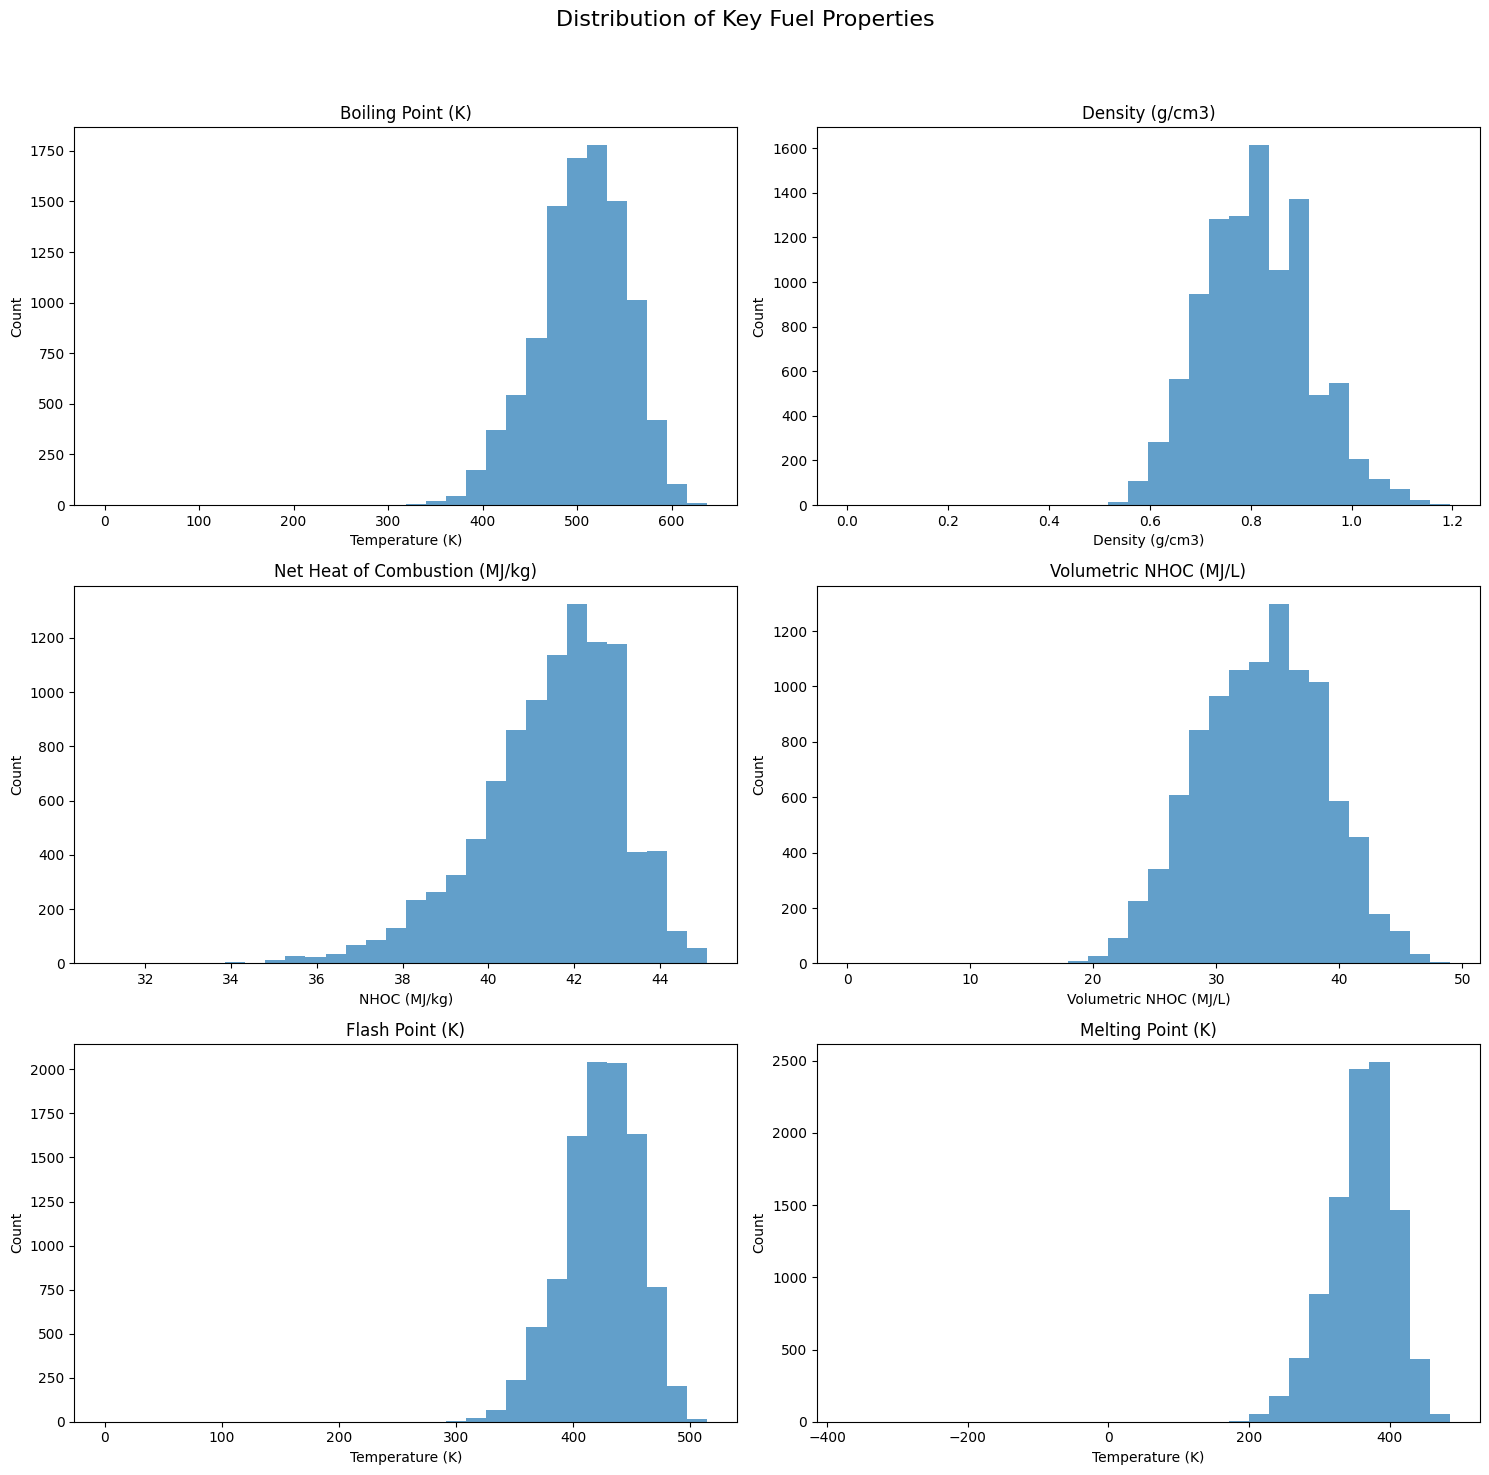

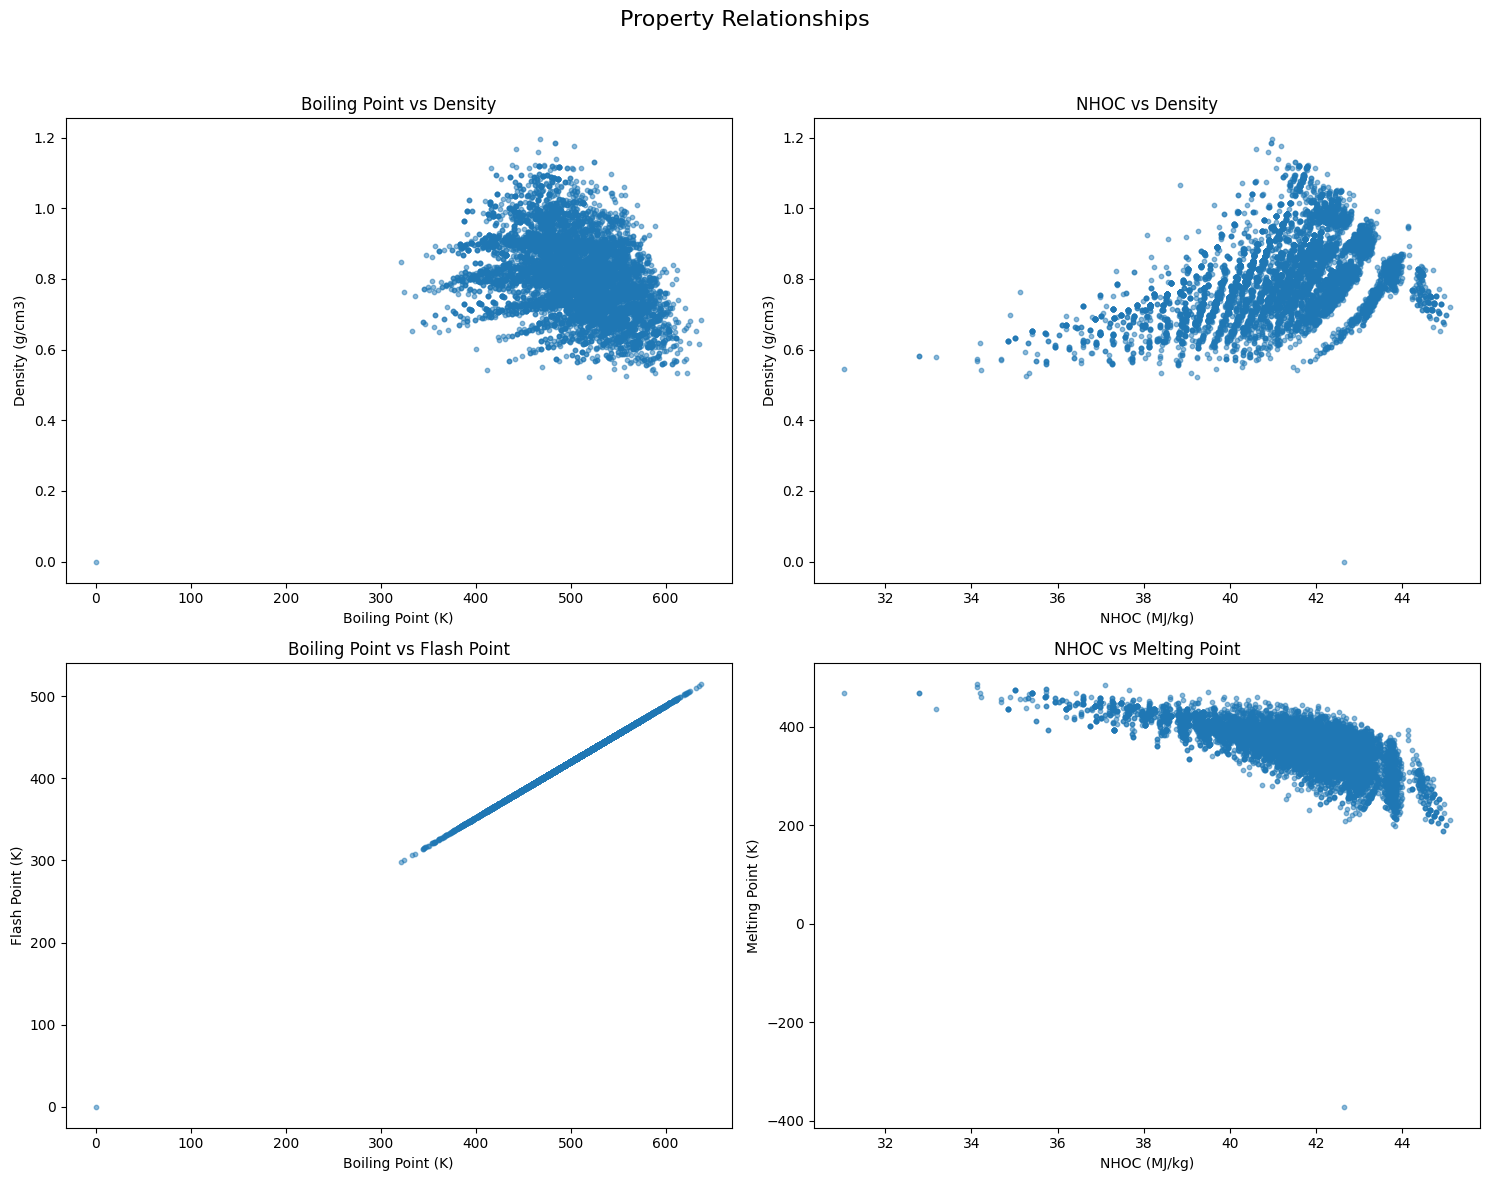


Analysis complete. Visualisation files saved to data directory.


In [48]:
# Define output path for the properties CSV
PROPERTIES_PATH = DATA_DIR / "molecule_properties.csv"

# Get SMILES from the 10k dataset
print("Preparing to calculate properties for the dataset...")

# Read the SMILES from the TRAIN_PATH file
train_smiles = []
with TRAIN_PATH.open('r') as f:
    for line in f:
        smi = line.strip()
        if smi:  # Skip empty lines
            train_smiles.append(smi)

# Verify we have the expected data
print(f"Found {len(train_smiles)} SMILES in the 10k training dataset")

# Process the dataset
process_smiles_dataset(train_smiles, PROPERTIES_PATH)

# Now let's generate some visualizations and statistics
print("\nGenerating statistics and visualizations...")

# Read the properties CSV
df = pd.read_csv(PROPERTIES_PATH)

# Basic statistics
print("\nBasic statistics:")
stats = df.describe()
print(stats)

# Create histograms for key properties
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
fig.suptitle('Distribution of Key Fuel Properties', fontsize=16)

# Boiling point
axes[0, 0].hist(df['boiling_point'].dropna(), bins=30, alpha=0.7)
axes[0, 0].set_title('Boiling Point (K)')
axes[0, 0].set_xlabel('Temperature (K)')
axes[0, 0].set_ylabel('Count')

# Density
axes[0, 1].hist(df['density'].dropna(), bins=30, alpha=0.7)
axes[0, 1].set_title('Density (g/cm3)')
axes[0, 1].set_xlabel('Density (g/cm3)')
axes[0, 1].set_ylabel('Count')

# NHOC
axes[1, 0].hist(df['nhoc'].dropna(), bins=30, alpha=0.7)
axes[1, 0].set_title('Net Heat of Combustion (MJ/kg)')
axes[1, 0].set_xlabel('NHOC (MJ/kg)')
axes[1, 0].set_ylabel('Count')

# Volumetric NHOC
axes[1, 1].hist(df['vol_nhoc'].dropna(), bins=30, alpha=0.7)
axes[1, 1].set_title('Volumetric NHOC (MJ/L)')
axes[1, 1].set_xlabel('Volumetric NHOC (MJ/L)')
axes[1, 1].set_ylabel('Count')

# Flash Point
axes[2, 0].hist(df['flash_point'].dropna(), bins=30, alpha=0.7)
axes[2, 0].set_title('Flash Point (K)')
axes[2, 0].set_xlabel('Temperature (K)')
axes[2, 0].set_ylabel('Count')

# Melting Point
axes[2, 1].hist(df['melting_point'].dropna(), bins=30, alpha=0.7)
axes[2, 1].set_title('Melting Point (K)')
axes[2, 1].set_xlabel('Temperature (K)')
axes[2, 1].set_ylabel('Count')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(DATA_DIR / "property_distributions.png", dpi=300)
plt.savefig(DATA_DIR / "property_distributions.pdf")
plt.savefig(DATA_DIR / "property_distributions.svg")
plt.show()

# Create scatter plots to examine relationships
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Property Relationships', fontsize=16)

# Boiling Point vs Density
axes[0, 0].scatter(df['boiling_point'], df['density'], alpha=0.5, s=10)
axes[0, 0].set_title('Boiling Point vs Density')
axes[0, 0].set_xlabel('Boiling Point (K)')
axes[0, 0].set_ylabel('Density (g/cm3)')

# NHOC vs Density
axes[0, 1].scatter(df['nhoc'], df['density'], alpha=0.5, s=10)
axes[0, 1].set_title('NHOC vs Density')
axes[0, 1].set_xlabel('NHOC (MJ/kg)')
axes[0, 1].set_ylabel('Density (g/cm3)')

# Flash Point vs Boiling Point
axes[1, 0].scatter(df['boiling_point'], df['flash_point'], alpha=0.5, s=10)
axes[1, 0].set_title('Boiling Point vs Flash Point')
axes[1, 0].set_xlabel('Boiling Point (K)')
axes[1, 0].set_ylabel('Flash Point (K)')

# NHOC vs Volumetric NHOC
axes[1, 1].scatter(df['nhoc'], df['melting_point'], alpha=0.5, s=10)
axes[1, 1].set_title('NHOC vs Melting Point')
axes[1, 1].set_xlabel('NHOC (MJ/kg)')
axes[1, 1].set_ylabel('Melting Point (K)')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(DATA_DIR / "property_relationships.png", dpi=600)
plt.savefig(DATA_DIR / "property_relationships.pdf")
plt.savefig(DATA_DIR / "property_relationships.svg")
plt.show()

print("\nAnalysis complete. Visualisation files saved to data directory.")